# Figure 3A/B/C, crossover recombination

In [1]:
%run ../../shared_setup.ipynb

The Cython magic has been move to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; Please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.


In [3]:
# load variation data
sample_exclusions = dup_samples.copy()
for cross in excessive_recomb_samples:
    sample_exclusions[cross] += excessive_recomb_samples[cross]

callsets = load_callsets(COMBINED_CALLSET_FN_TEMPLATE, 
                         sample_exclusions=sample_exclusions, 
                         variant_filter='FILTER_PASS',
                         call_filter=combined_conf_calls)

samples = {cross: callsets[cross]['calldata'].dtype.names
           for cross in CROSSES}
progeny = {cross: samples[cross][2:] for cross in CROSSES}
n_progeny = {cross: len(progeny[cross]) for cross in CROSSES}
print(n_progeny)
print(np.sum(list(n_progeny.values())))

2015-04-02 21:45:27.071982 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/3d7_hb3.combined.final.npz
2015-04-02 21:45:27.362556 :: filter variants: excluding 157 (0.4%) retaining 42087 (99.6%) of 42244 variants
2015-04-02 21:45:27.379444 :: filter samples: excluding ['C01/PG0062-C/ERR019070', 'C02/PG0053-C/ERR019067', 'C02/PG0055-C/ERR019066', 'C02/PG0056-C/ERR019068'] including ['3D7/PG0051-C/ERR019061', 'HB3/PG0052-C/ERR019054', 'C01/PG0065-C/ERR019064', 'C02/PG0067-C/ERR019073', 'C03/PG0066-C/ERR019072', 'C04/PG0061-C/ERR019059', 'C05/PG0068-C/ERR019065', 'C06/PG0069-C/ERR019055', 'C07/PG0070-C/ERR019056', 'C08/PG0071-C/ERR019074', 'C09/PG0072-C/ERR019057', 'C10/PG0063-C/ERR019060', 'C11/PG0064-C/ERR019071', 'C12/PG0058-C/ERR019063', 'C13/PG0054-C/ERR019062', 'C14/PG0060-C/ERR019058', 'C15/PG0057-C/ERR019069']
2015-04-02 21:45:27.458429 :: filter calls: excluding 2216 (0.3%) retaining 713263 (99.7%) of 715479 calls
2015-04-02 21:45:27.459428 :: loading /data

{'hb3_dd2': 34, '3d7_hb3': 15, '7g8_gb4': 27}
76


## How many CO events in total?

In [4]:
tbl_co = etl.frompickle(os.path.join(PUBLIC_DIR, 'tbl_co.pickle'))
display_with_nrows(tbl_co, caption='CO events')

0|sample,1|chrom,2|co_pos_mid,3|co_pos_min,4|co_pos_max,5|co_pos_range,6|cross,7|co_from_parent,8|co_to_parent
B1SD/PG0015-C/ERR019044,b'Pf3D7_01_v3',145052,144877,145227,350,hb3_dd2,hb3,dd2
GC03/PG0021-C/ERR015447,b'Pf3D7_01_v3',163584,163145,164024,879,hb3_dd2,dd2,hb3
XF12/PG0102-C/ERR029143,b'Pf3D7_01_v3',206769,205803,207736,1933,7g8_gb4,gb4,7g8
7C159/PG0040-Cx/ERR107475,b'Pf3D7_01_v3',206905,206074,207736,1662,hb3_dd2,hb3,dd2
CH3_61/PG0033-Cx/ERR175544,b'Pf3D7_01_v3',206905,206074,207736,1662,hb3_dd2,dd2,hb3


In [5]:
(tbl_co
 .valuecounts('cross')
  .addfield('count_per_meiosis', 
            lambda row: row['count'] / n_progeny[row['cross']])
 .display(caption='CO events by cross')
)

0|cross,1|count,2|frequency,3|count_per_meiosis
hb3_dd2,544,0.4556113902847571,16.0
7g8_gb4,385,0.3224455611390285,14.25925925925926
3d7_hb3,265,0.2219430485762144,17.666666666666668


## CO recombination rate

In [8]:
# the simple method...
X = tbl_co.valuecounts('sample').values('count').list()

n = len(X)
assert np.sum(list(n_progeny.values())) == n
print('meioses:', n)

print('crossovers:', np.sum(X))

mu_hat = np.mean(X)
print('total map length: %.2f' % mu_hat, 'Morgan')

mu_stderr = np.sqrt(mu_hat / n)
print('map length stderr:', mu_stderr)

mu_95ci = 1.96 * mu_stderr
print('map length 95%% CI: %.2f - %.2f' % (mu_hat - mu_95ci, mu_hat + mu_95ci))

meioses: 76
crossovers: 1194
total map length: 15.71 Morgan
map length stderr: 0.454661909031
map length 95% CI: 14.82 - 16.60


In [9]:
# calculate marker span using accessibility regions, it's fairer and simpler
tbl_marker_span = (
    tbl_regions_1b
    .eq('region_type', 'Core')
    .aggregate(key='region_chrom', 
               aggregation={'start': ('region_start', min), 'stop': ('region_stop', max)})
    .rename('region_chrom', 'chrom')
    .addfield('span', lambda row: row.stop - row.start)
)
total_marker_span = tbl_marker_span.values('span').sum()
tbl_marker_span.displayall(caption='Core genome span (total = %.2f)' % (total_marker_span/1e6))

0|chrom,1|stop,2|start,3|span
Pf3D7_01_v3,575900,92901,482999
Pf3D7_02_v3,862500,105801,756699
Pf3D7_03_v3,1003060,70631,932429
Pf3D7_04_v3,1143990,91421,1052569
Pf3D7_05_v3,1321390,37901,1283489
Pf3D7_06_v3,1294830,72351,1222479
Pf3D7_07_v3,1381600,77101,1304499
Pf3D7_08_v3,1365730,73561,1292169
Pf3D7_09_v3,1473560,79101,1394459
Pf3D7_10_v3,1571815,68971,1502844


In [10]:
co_hat = (mu_hat / (total_marker_span / 1e6))
print('CO rate: %.4f Morgan/Mb' % co_hat)
co_95ci_lower = (mu_hat - mu_95ci) / (total_marker_span / 1e6)
co_95ci_upper = (mu_hat + mu_95ci) / (total_marker_span / 1e6)
print('CO rate 95%% CI: %.4f - %.4f Morgan/Mb' % (co_95ci_lower, co_95ci_upper))
print()
print('CO rate: %.1f kb/cM' % (10/co_hat))
print('CO rate 95%% CI: %.1f - %.1f kb/cM' % (10/co_95ci_upper, 10/co_95ci_lower))

CO rate: 0.7425 Morgan/Mb
CO rate 95% CI: 0.7004 - 0.7846 Morgan/Mb

CO rate: 13.5 kb/cM
CO rate 95% CI: 12.7 - 14.3 kb/cM


## CO rate by progeny

In [11]:
tbl_co.valuecounts('sample', 'cross').head(5).display()
tbl_co.valuecounts('sample', 'cross').tail(5).display()

0|sample,1|cross,2|count,3|frequency
C04/PG0061-C/ERR019059,3d7_hb3,26,0.021775544388609715
7C408/PG0031-C/ERR015458,hb3_dd2,25,0.020938023450586266
SC05/PG0019-C/ERR019051,hb3_dd2,23,0.019262981574539362
C14/PG0060-C/ERR019058,3d7_hb3,22,0.018425460636515914
CH3_61/PG0033-Cx/ERR175544,hb3_dd2,22,0.018425460636515914


0|sample,1|cross,2|count,3|frequency
XB3/PG0093-C/ERR029105,7g8_gb4,9,0.007537688442211055
WE2/PG0085-C/ERR027101,7g8_gb4,8,0.006700167504187605
B4R3/PG0018-C/ERR019042,hb3_dd2,8,0.006700167504187605
7C16/PG0036-C/ERR015455,hb3_dd2,7,0.005862646566164154
JON/PG0107-C/ERR029408,7g8_gb4,5,0.0041876046901172526


## CO rate by cross

In [12]:
# the simple method...

for cross in CROSSES:
    
    print()
    print(LABELS[cross])
    X = tbl_co.eq('cross', cross).valuecounts('sample').values('count').list()

    n = len(X)
    assert n_progeny[cross] == n
    print('meioses:', n)

    print('crossovers:', np.sum(X))

    mu_hat = np.mean(X)
    print('total map length: %.2f' % mu_hat, 'Morgan')

    mu_stderr = np.sqrt(mu_hat / n)
    print('map length stderr:', mu_stderr)

    mu_95ci = 1.96 * mu_stderr
    print('map length 95%% CI: %.2f - %.2f' % (mu_hat - mu_95ci, mu_hat + mu_95ci))


3D7 x HB3
meioses: 15
crossovers: 265
total map length: 17.67 Morgan
map length stderr: 1.08525470641
map length 95% CI: 15.54 - 19.79

HB3 x Dd2
meioses: 34
crossovers: 544
total map length: 16.00 Morgan
map length stderr: 0.68599434057
map length 95% CI: 14.66 - 17.34

7G8 x GB4
meioses: 27
crossovers: 385
total map length: 14.26 Morgan
map length stderr: 0.726719143346
map length 95% CI: 12.83 - 15.68


In [13]:
df_co_by_sample = (
    tbl_co
    .valuecounts('cross', 'sample')
    .sort(key=('cross', 'sample'))
    .rename('count', 'n_co')
    .todataframe()
)
df_co_by_sample.head()

,cross,sample,n_co,frequency
0,3d7_hb3,C01/PG0065-C/ERR019064,15,0.012563
1,3d7_hb3,C02/PG0067-C/ERR019073,15,0.012563
2,3d7_hb3,C03/PG0066-C/ERR019072,17,0.014238
3,3d7_hb3,C04/PG0061-C/ERR019059,26,0.021776
4,3d7_hb3,C05/PG0068-C/ERR019065,11,0.009213


In [15]:
vals = [df_co_by_sample[df_co_by_sample.cross == cross]['n_co'].values for cross in CROSSES]

f_val, p_val = stats.f_oneway(*vals)
print('ANOVA', f_val, p_val)

h_val, p_val = stats.kruskal(*vals)
print('Kruskal', h_val, p_val)

ANOVA 3.20793043117 0.0462029646224
Kruskal 5.53134398344 0.0629337941466


In [16]:
len(df_co_by_sample)

76

In [17]:
def plot_co_rate_by_cross(ax):
    X = df_co_by_sample.n_co
    F = df_co_by_sample.cross
    vals = [X[F == cross] for cross in CROSSES]
    sns.despine(ax=ax)
    sns.despine(ax=ax, offset=5)
    #sns.violinplot(vals, ax=ax, linewidth=.5, )
    #sns.boxplot(vals, ax=ax)
    ax.boxplot(vals, notch=True, bootstrap=10000)
    ax.set_xticklabels([LABELS[cross] for cross in CROSSES], fontsize=8)
    ax.set_ylim(0, 30)
    ax.set_ylabel('CO recombination rate (Morgan)')


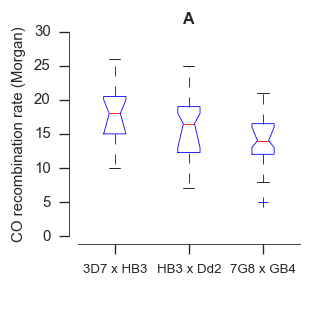

In [18]:
width = 8/3
height = width 
fig, ax = plt.subplots(figsize=(width, height))
ax.set_xlabel('cross', color='w')
plot_co_rate_by_cross(ax)
ax.set_title('A', fontweight='bold')
fig.tight_layout()
fig.savefig('../../artwork/main/fig3A.jpg', dpi=900, jpeg_quality=100)

## CO rate by chromosome

In [21]:
lkp_span = tbl_marker_span.lookupone('chrom', 'span')
lkp_span

{'Pf3D7_01_v3': 482999,
 'Pf3D7_02_v3': 756699,
 'Pf3D7_03_v3': 932429,
 'Pf3D7_04_v3': 1052569,
 'Pf3D7_05_v3': 1283489,
 'Pf3D7_06_v3': 1222479,
 'Pf3D7_07_v3': 1304499,
 'Pf3D7_08_v3': 1292169,
 'Pf3D7_09_v3': 1394459,
 'Pf3D7_10_v3': 1502844,
 'Pf3D7_11_v3': 1893319,
 'Pf3D7_12_v3': 2103399,
 'Pf3D7_13_v3': 2717486,
 'Pf3D7_14_v3': 3219935}

In [22]:
tbl_co_by_chrom = [['cross', 'sample', 'chrom', 'count']]

for cross, sample in sorted(tbl_co.values(('cross', 'sample')).set()):
    for chrom in CHROMOSOMES:
        n = tbl_co.select(lambda row: row.cross == cross and row.sample == sample and row.chrom == chrom).nrows()
        tbl_co_by_chrom.append([cross, sample, chrom, n])

tbl_co_by_chrom = (etl
    .wrap(tbl_co_by_chrom)
    .addfield('span', lambda row: lkp_span[str(row.chrom, 'ascii')])
)
tbl_co_by_chrom.display()

0|cross,1|sample,2|chrom,3|count,4|span
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_01_v3',0,482999
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_02_v3',0,756699
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_03_v3',1,932429
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_04_v3',0,1052569
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_05_v3',1,1283489


In [23]:
df_co_by_chrom = tbl_co_by_chrom.todataframe()

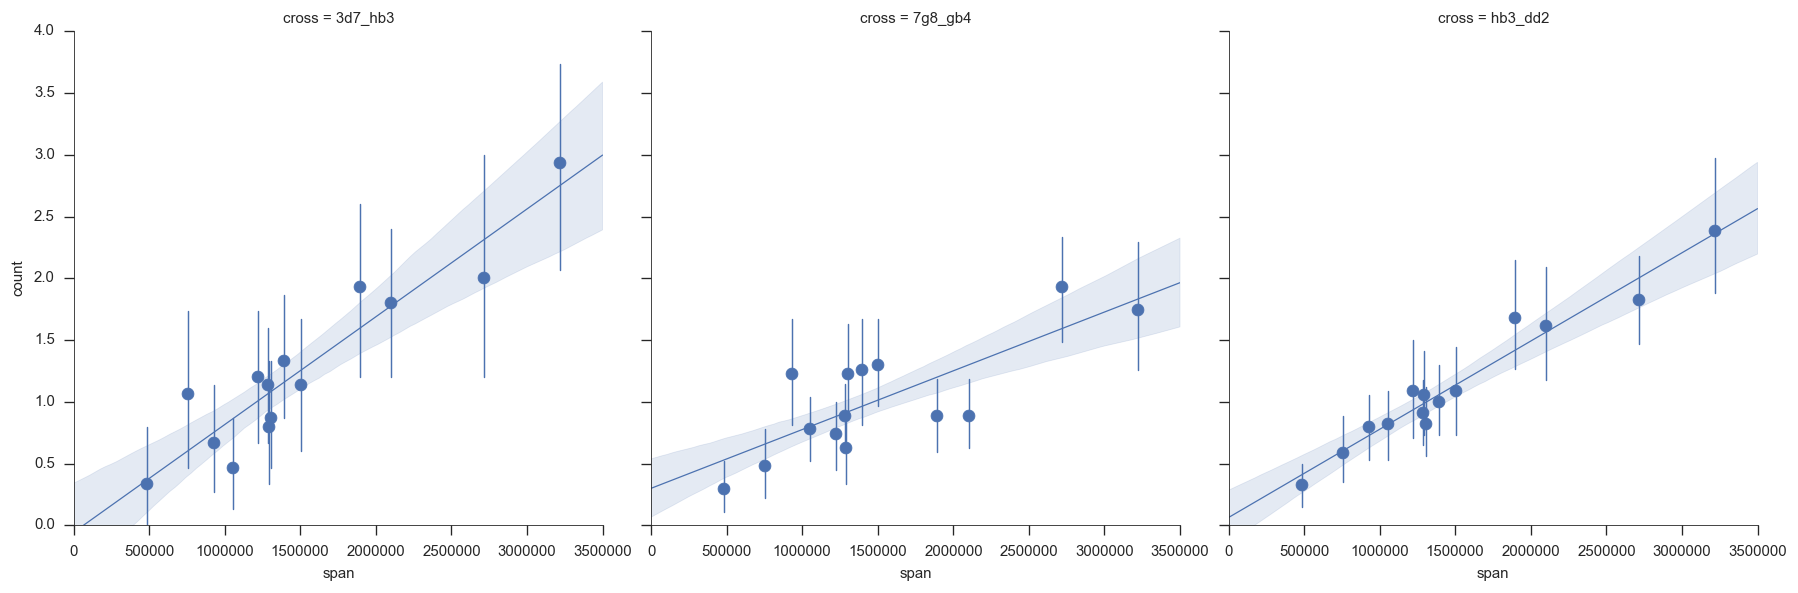

In [24]:
plot = sns.lmplot('span', 'count', df_co_by_chrom, x_estimator=np.mean, col='cross')
plot.set(ylim=(0, 4));

In [25]:
def plot_co_rate_by_chrom(ax, scatter_kws=dict()):
    sns.despine(ax=ax)
    sns.offset_spines(ax=ax)
    sns.regplot('span', 'count', df_co_by_chrom, x_estimator=np.mean, scatter_kws=scatter_kws, ax=ax)
    ax.set_xlabel('chromosome marker span (bp)')
    ax.set_ylabel('CO recombination rate (Morgan)')
    ax.set_ylim(0, 3)


/home/aliman/pyenv/science_py3/lib/python3.4/site-packages/seaborn/utils.py:247: UserWarning: `offset_spines` is deprecated and will be removed in v0.5
  warnings.warn(warn_msg, UserWarning)


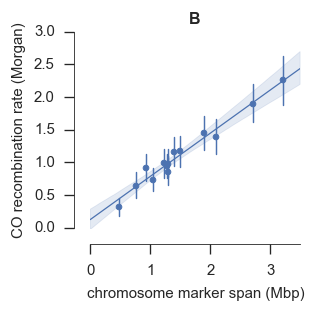

In [26]:
width = 8/3
height = width
fig, ax = plt.subplots(figsize=(width, height))
plot_co_rate_by_chrom(ax, scatter_kws=dict(s=12))
ax.set_xticks(range(0, 3500000, 1000000))
ax.set_xticklabels(range(0, 4, 1))
ax.set_xlabel('chromosome marker span (Mbp)')
ax.set_title('B', fontweight='bold')
fig.tight_layout()
fig.savefig('../../artwork/main/fig3B.jpg', dpi=900, jpeg_quality=100)

## CO rate relative to centromere

TODO redo with newer genome annotations to get an extra centromere

In [30]:
def distance_to_centromere(row):
    cen_id = 'PF3D7_CEN' + str(row.chrom[6:8], 'ascii')
    cen = lkp_feature[cen_id]
    cen_pos = (cen['feature_start'] + cen['feature_stop'])/2
    return abs(row.co_pos_mid - cen_pos)

df_co_cen = (
    tbl_co
    .lt('co_pos_range', 10000)  # require 10kb certainty
    .ne('chrom', b'Pf3D7_10_v3')  # no centromere
    .todataframe()
)
df_co_cen['cen_dist'] = df_co_cen.apply(distance_to_centromere, axis=1)
print(len(df_co_cen))
df_co_cen.head()

1087


,sample,chrom,co_pos_mid,co_pos_min,co_pos_max,co_pos_range,cross,co_from_parent,co_to_parent,cen_dist
0,B1SD/PG0015-C/ERR019044,b'Pf3D7_01_v3',145052,144877,145227,350,hb3_dd2,hb3,dd2,314069
1,GC03/PG0021-C/ERR015447,b'Pf3D7_01_v3',163584,163145,164024,879,hb3_dd2,dd2,hb3,295537
2,XF12/PG0102-C/ERR029143,b'Pf3D7_01_v3',206769,205803,207736,1933,7g8_gb4,gb4,7g8,252352
3,7C159/PG0040-Cx/ERR107475,b'Pf3D7_01_v3',206905,206074,207736,1662,hb3_dd2,hb3,dd2,252216
4,CH3_61/PG0033-Cx/ERR175544,b'Pf3D7_01_v3',206905,206074,207736,1662,hb3_dd2,dd2,hb3,252216


In [34]:
def get_cen_pos(chrom):
    cen_id = 'PF3D7_CEN' + chrom[6:8]
    cen = lkp_feature[cen_id]
    return cen['feature_start'], cen['feature_stop']

tbl_chrom_cen = (
    tbl_regions_1b
    .ne('region_chrom', 'Pf3D7_10_v3')
    .eq('region_type', 'Core')
    .aggregate(key='region_chrom', 
               aggregation={'core_start': ('region_start', min), 'core_stop': ('region_stop', max)})
    .rename('region_chrom', 'chrom')
    .addfield('cen', lambda row: get_cen_pos(row.chrom))
    .unpack('cen', ['cen_start', 'cen_stop'])
    .addfield('cen_pos', lambda row: (row.cen_start + row.cen_stop)/2)
)
tbl_chrom_cen

0|chrom,1|core_stop,2|core_start,3|cen_start,4|cen_stop,5|cen_pos
Pf3D7_01_v3,575900,92901,457931,460311,459121.0
Pf3D7_02_v3,862500,105801,447300,450450,448875.0
Pf3D7_03_v3,1003060,70631,597816,600275,599045.5
Pf3D7_04_v3,1143990,91421,642003,644529,643266.0
Pf3D7_05_v3,1321390,37901,455740,457252,456496.0


In [47]:
def plot_co_rate_cen(window_size=20000, ax=None, scatter_kws=dict()):
    XX = list()  # distance to centromere
    YY = list()  # CO recombination rate

    # N.B., we need to account for the fact that some chromosomes are bigger than others.
    # Consider each chromosome separately, move upstream and downstream of centromere separately.
    # Gather what data there are.
    # Should mean that estimates of recombination rate further from centromere have greater uncertainty.
    # However should not mean there is any other effect of chromosome size.
    for row in tbl_chrom_cen.records():
        
        # downstream
        max_dist = row.core_stop - row.cen_pos
        bins = np.arange(0, max_dist, window_size)
        X = (bins[:-1] + bins[1:])/2.
        # recombination rate
        D = df_co_cen[(df_co_cen.chrom == row.chrom.encode('ascii')) & (df_co_cen.co_pos_min > row.cen_pos)].cen_dist
        Y, _ = np.histogram(D, bins=bins)
        XX.append(X)
        YY.append(Y)
        
        # upstream
        min_dist = row.cen_pos - row.core_start
        bins = np.arange(0, min_dist, window_size)
        X = (bins[:-1] + bins[1:])/2.
        # recombination rate
        D = df_co_cen[(df_co_cen.chrom == row.chrom.encode('ascii')) & (df_co_cen.co_pos_max < row.cen_pos)].cen_dist
        Y, _ = np.histogram(D, bins=bins)
        XX.append(X)
        YY.append(Y)
    
    XX = np.concatenate(XX)
    YY = np.concatenate(YY)
    YY = YY / np.sum(list(n_progeny.values()))  # Morgan
    YY = YY / (window_size/1e6)  # Morgan/Mbp
    
    if ax is None:
        fig, ax = plt.subplots()
    sns.despine(ax=ax, offset=5)
    sns.regplot(XX, YY, x_estimator=np.mean, x_ci=95, ax=ax, fit_reg=False, scatter_kws=scatter_kws)
    ax.set_xlim(0, 700000)
    ax.set_ylim(0, 2)
    ax.set_ylabel('CO recombination rate (Morgan/Mbp)')
    ax.set_xlabel('distance from centromere (bp)')
    ax.axhline(np.mean(YY), linestyle=':', linewidth=.5)
    
    

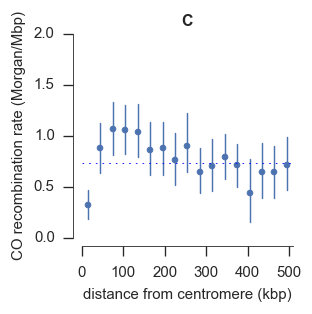

In [48]:
width = 8/3
height = width
fig, ax = plt.subplots(figsize=(width, height))
plot_co_rate_cen(30000, ax=ax, scatter_kws=dict(s=12))
ax.set_xlim(0, 510000)
ax.set_xticks(range(0, 600000, 100000))
ax.set_xticklabels(range(0, 600, 100))
ax.set_xlabel('distance from centromere (kbp)')
ax.set_title('C', fontweight='bold')
fig.tight_layout()
fig.savefig('../../artwork/main/fig3C.jpg', dpi=900, jpeg_quality=100)

In [49]:
8 * 2.54

20.32

In [50]:
(16/3)*2.54

13.546666666666667